<a href="https://colab.research.google.com/github/grace-arina/Skin-Lesion-Detection-Using-Neural-Networks/blob/models/ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install opendatasets

In [3]:
import opendatasets as od
od.download('https://www.kaggle.com/drscarlat/melanoma')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: gracearina
Your Kaggle Key: ··········


100%|██████████| 5.26G/5.26G [01:58<00:00, 47.6MB/s]


Import Modules

In [4]:
# IMPORT MODULES
import sys
from os.path import join
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import ResNet50

from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import datetime
import itertools
import os.path
import os
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, f1_score, roc_auc_score

%load_ext tensorboard

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
sys.path.append('/content/drive/MyDrive/Colab Notebooks')

In [7]:
import funct

In [8]:
train_dir = '/content/melanoma/DermMel/train_sep'
test_dir = '/content/melanoma/DermMel/test/'
val_dir = '/content/melanoma/DermMel/valid'

Data Preprocessing

In [ ]:
idg = ImageDataGenerator(rescale=1./255)

train_set = idg.flow_from_directory(train_dir, 
                                    target_size=(224, 224),
                                    classes=['Melanoma', 'NotMelanoma'])

val_set = idg.flow_from_directory(val_dir,
                                  target_size=(224, 224),
                                  classes=['Melanoma', 'NotMelanoma'])

test_set = idg.flow_from_directory(test_dir,
                                   target_size=(224, 224),
                                   classes=['Melanoma', 'NotMelanoma'],
                                   shuffle=False)

Found 10682 images belonging to 2 classes.
Found 3562 images belonging to 2 classes.
Found 3561 images belonging to 2 classes.


In [ ]:
# Pulling out images and labels from the image sets for visualizing
train_imgs, train_labels = next(train_set)
val_imgs, val_labels = next(val_set)
test_imgs, test_labels = next(test_set)

In [ ]:
print(train_set.class_indices)
print(val_set.class_indices)
print(test_set.class_indices)
for data_batch, labels_batch in train_set:
  print("Train shape:", data_batch.shape)
  print("Train labels shape:", labels_batch.shape)
  break
for data_batch, labels_batch in val_set:
  print("Validation shape:", data_batch.shape)
  print("Validation labels shape:", labels_batch.shape)
  break
for data_batch, labels_batch in test_set:
  print("Test shape:", data_batch.shape)
  print("Test labels shape:", labels_batch.shape)
  break

{'Melanoma': 0, 'NotMelanoma': 1}
{'Melanoma': 0, 'NotMelanoma': 1}
{'Melanoma': 0, 'NotMelanoma': 1}
Train shape: (32, 224, 224, 3)
Train labels shape: (32, 2)
Validation shape: (32, 224, 224, 3)
Validation labels shape: (32, 2)
Test shape: (32, 224, 224, 3)
Test labels shape: (32, 2)


Visualizations

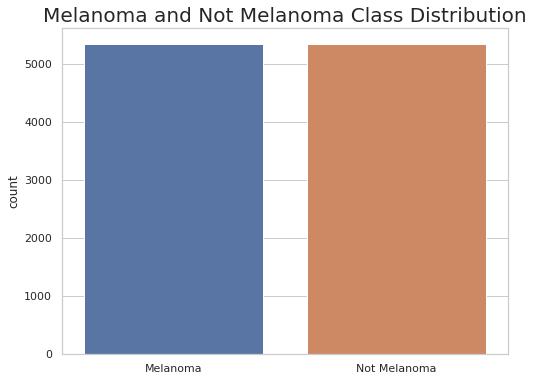

In [ ]:
import seaborn as sns

# Creating a series of the training labels and mapping on readable names
class_labels = pd.Series(train_set.labels).map({0: 'Melanoma', 
                                                   1: 'Not Melanoma'})

# Plotting the distribution of the classes
fig, ax = plt.subplots(figsize=(8,6)) 
ax = sns.countplot(x=class_labels)
ax.set_title('Melanoma and Not Melanoma Class Distribution', 
             fontdict={'fontsize': 20});

In [ ]:
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 10, figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip(images_arr[:10], axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

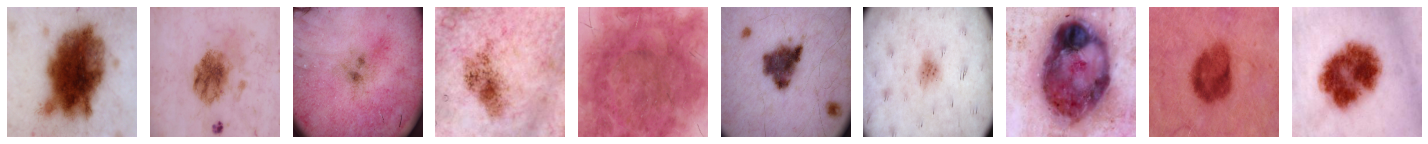

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [ ]:
plotImages(train_imgs)
print(train_labels[:10])

### Build a Baseline Model

In [ ]:
# Setting paramaters on early stopping
earlystop = EarlyStopping(monitor='val_acc',
                          patience=10,
                          verbose=1)

In [ ]:
log_dir = "/content/drive/MyDrive/Colab Notebooks/logs/fit/model_base"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [ ]:
model_base = Sequential()
model_base.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
model_base.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2))
model_base.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
model_base.add(layers.Flatten())
model_base.add(layers.Dense(units=2, activation='softmax'))


In [ ]:
model_base.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 flatten (Flatten)           (None, 802816)            0         
                                                                 
 dense (Dense)               (None, 2)                 1605634   
                                                                 
Total params: 1,625,026
Trainable params: 1,625,026
Non-trainable params: 0
______________________________________________

In [ ]:
model_base.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
history_base = model_base.fit(train_set,
                       validation_data=val_set,
                       steps_per_epoch=100,
                       epochs=30,
                       callbacks=[earlystop, tensorboard_callback])

Epoch 1/30
100/100 [==============================] - 70s 585ms/step - loss: 2.3087 - acc: 0.6066 - val_loss: 0.6215 - val_acc: 0.6457
Epoch 2/30
100/100 [==============================] - 50s 507ms/step - loss: 0.6337 - acc: 0.6544 - val_loss: 0.6384 - val_acc: 0.6280
Epoch 3/30
100/100 [==============================] - 48s 483ms/step - loss: 0.6079 - acc: 0.6628 - val_loss: 0.5993 - val_acc: 0.6769
Epoch 4/30
100/100 [==============================] - 48s 482ms/step - loss: 0.5910 - acc: 0.6763 - val_loss: 0.7237 - val_acc: 0.5786
Epoch 5/30
100/100 [==============================] - 48s 480ms/step - loss: 0.6037 - acc: 0.6678 - val_loss: 0.6095 - val_acc: 0.6842
Epoch 6/30
100/100 [==============================] - 47s 475ms/step - loss: 0.5836 - acc: 0.6828 - val_loss: 0.5682 - val_acc: 0.6954
Epoch 7/30
100/100 [==============================] - 47s 468ms/step - loss: 0.5580 - acc: 0.7047 - val_loss: 0.5665 - val_acc: 0.6940
Epoch 8/30
100/100 [==============================] - 4

In [ ]:
#Checks first to see if file exists already. If not, the model is saved to disk

import os.path
if os.path.isfile('/content/drive/MyDrive/Colab Notebooks/models/model_base.h5') is False:
  model_base.save('/content/drive/MyDrive/Colab Notebooks/models/model_base.h5')

Model Evaluation

In [ ]:
model_base.evaluate(test_set)

112/112 [==============================] - 26s 232ms/step - loss: 0.4149 - acc: 0.8183


[0.4148785173892975, 0.818309485912323]

In [ ]:
pred_base = model_base.predict(test_set, verbose=0)
pred_base

array([[0.8852089 , 0.11479109],
       [0.88050765, 0.11949233],
       [0.93347657, 0.06652343],
       ...,
       [0.52075595, 0.47924405],
       [0.55480367, 0.4451963 ],
       [0.32217106, 0.67782897]], dtype=float32)

[[1544  237]
 [ 410 1370]]


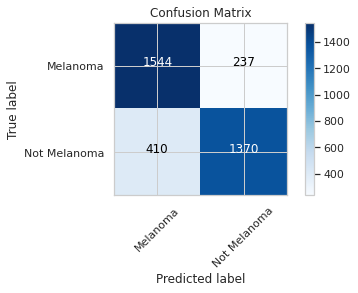

In [ ]:
funct.plot_cm(y_true=test_set.classes, y_pred=np.argmax(pred_base, axis=-1), classes=["Melanoma", "Not Melanoma"])

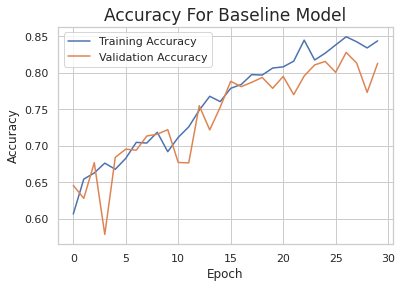

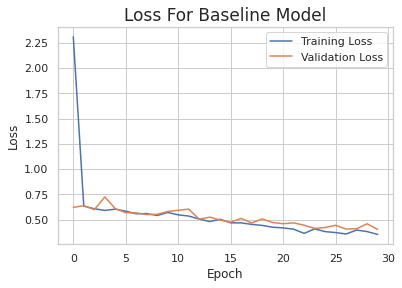

In [ ]:
funct.plot_model_metrics(hist=history_base, label='Baseline Model')

## Build Fine-Tuned ResNet50 Models

Data Preprocessing and Augmentation

In [9]:
train_datagen = ImageDataGenerator(rotation_range=40,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               preprocessing_function=preprocess_input
                               )
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input
                             )

train_gen = train_datagen.flow_from_directory(train_dir, 
                                    target_size=(224, 224),
                                    classes=['Melanoma', 'NotMelanoma'])

val_gen = val_datagen.flow_from_directory(val_dir,
                                  target_size=(224, 224),
                                  classes=['Melanoma', 'NotMelanoma'])

test_gen = val_datagen.flow_from_directory(test_dir,
                                   target_size=(224, 224),
                                   classes=['Melanoma', 'NotMelanoma'],
                                   shuffle=False)

Found 10682 images belonging to 2 classes.
Found 3562 images belonging to 2 classes.
Found 3561 images belonging to 2 classes.


### First Model

In [ ]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94781440/94765736 [==============================] - 2s 0us/step


In [ ]:
resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
#Convert the ResNet50 model to a sequential model

resnet_1 = Sequential()
resnet_1.add(resnet_model)
resnet_1.add(layers.Flatten())
resnet_1.add(layers.Dropout(0.5))
resnet_1.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
resnet_1.add(layers.Dropout(0.5))
resnet_1.add(layers.Dense(2, activation='softmax'))

In [ ]:
for layer in resnet_model.layers:
  layer.trainable = False

In [ ]:
resnet_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dropout (Dropout)           (None, 100352)            0         
                                                                 
 dense_1 (Dense)             (None, 64)                6422592   
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 30,010,434
Trainable params: 6,422,722
N

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
resnet_1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])


In [ ]:
log_dir = "/content/drive/MyDrive/Colab Notebooks/logs/fit/resnet_1"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
history_rn1 = resnet_1.fit(train_gen,
                       validation_data=val_gen,
                       steps_per_epoch=100,
                       epochs=30,
                       callbacks=[#earlystop,
                                  tensorboard_callback
                                  ])

Epoch 1/30
100/100 [==============================] - 105s 1s/step - loss: 0.4754 - acc: 0.7890 - val_loss: 0.8578 - val_acc: 0.5000
Epoch 2/30
100/100 [==============================] - 99s 998ms/step - loss: 0.3322 - acc: 0.8703 - val_loss: 0.7359 - val_acc: 0.5000
Epoch 3/30
100/100 [==============================] - 97s 971ms/step - loss: 0.2943 - acc: 0.8823 - val_loss: 0.7752 - val_acc: 0.5067
Epoch 4/30
100/100 [==============================] - 96s 966ms/step - loss: 0.2820 - acc: 0.8888 - val_loss: 0.8096 - val_acc: 0.5039
Epoch 5/30
100/100 [==============================] - 96s 960ms/step - loss: 0.2638 - acc: 0.8929 - val_loss: 0.8911 - val_acc: 0.5017
Epoch 6/30
100/100 [==============================] - 97s 969ms/step - loss: 0.2628 - acc: 0.8941 - val_loss: 0.9441 - val_acc: 0.5017
Epoch 7/30
100/100 [==============================] - 96s 966ms/step - loss: 0.2564 - acc: 0.9028 - val_loss: 1.0133 - val_acc: 0.5014
Epoch 8/30
100/100 [==============================] - 96s

In [ ]:
if os.path.isfile('/content/drive/MyDrive/Colab Notebooks/models/resnet_1.h5') is False:
  resnet_1.save('/content/drive/MyDrive/Colab Notebooks/models/resnet_1.h5')

In [ ]:
resnet_1.evaluate(test_gen)

112/112 [==============================] - 31s 274ms/step - loss: 0.1919 - acc: 0.9323


[0.19194145500659943, 0.9323223829269409]

In [10]:
resnet1 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/models/resnet_1.h5')

In [11]:
pred_rn1 = resnet1.predict(test_gen, verbose=0)
pred_rn1

array([[9.9999809e-01, 1.9428182e-06],
       [9.9999249e-01, 7.5231310e-06],
       [9.9999976e-01, 2.8308122e-07],
       ...,
       [2.3799595e-01, 7.6200402e-01],
       [8.8267575e-04, 9.9911731e-01],
       [4.3726039e-01, 5.6273955e-01]], dtype=float32)

[[1541  240]
 [   1 1779]]


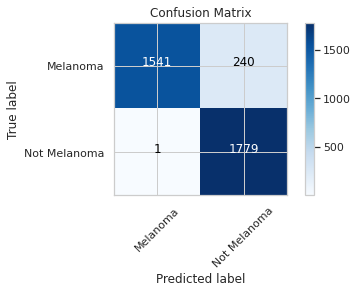

In [14]:
funct.plot_cm(y_true=test_gen.classes, y_pred=np.argmax(pred_rn1, axis=-1), classes=["Melanoma", "Not Melanoma"])

In [16]:
funct.plot_model_metrics(hist=history_1, label='ResNet50_Model_1')

### Second Model

In [ ]:
preprocess = ImageDataGenerator(preprocessing_function=preprocess_input
                               )


train_dataset = preprocess.flow_from_directory(train_dir, 
                                    target_size=(224, 224),
                                    classes=['Melanoma', 'NotMelanoma'])

val_dataset = preprocess.flow_from_directory(val_dir,
                                  target_size=(224, 224),
                                  classes=['Melanoma', 'NotMelanoma'])

test_dataset = preprocess.flow_from_directory(test_dir,
                                   target_size=(224, 224),
                                   classes=['Melanoma', 'NotMelanoma'],
                                   shuffle=False)

Found 10682 images belonging to 2 classes.
Found 3562 images belonging to 2 classes.
Found 3561 images belonging to 2 classes.


In [ ]:
resnet_model2 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
resnet_2 = Sequential()
resnet_2.add(resnet_model2)
resnet_2.add(layers.Flatten())
resnet_2.add(layers.Dropout(0.5))
resnet_2.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
resnet_2.add(layers.Dropout(0.5))
resnet_2.add(layers.Dense(2, activation='softmax'))

In [ ]:
for layer in resnet_model2.layers[:-3]:
  layer.trainable = False

In [ ]:
resnet_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 100352)            0         
                                                                 
 dropout_4 (Dropout)         (None, 100352)            0         
                                                                 
 dense_5 (Dense)             (None, 64)                6422592   
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 2)                 130       
                                                                 
Total params: 30,010,434
Trainable params: 6,426,818
N

In [ ]:
resnet_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])


In [ ]:
log_dir = "/content/drive/MyDrive/Colab Notebooks/logs/fit/resnet_2"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
history_rn2 = resnet_2.fit(train_dataset,
                       validation_data=val_dataset,
                       steps_per_epoch=100,
                       epochs=200,
                       callbacks=[earlystop, tensorboard_callback])

Epoch 1/200
100/100 [==============================] - 117s 1s/step - loss: 1.2838 - acc: 0.7803 - val_loss: 0.3844 - val_acc: 0.8855
Epoch 2/200
100/100 [==============================] - 62s 619ms/step - loss: 0.4964 - acc: 0.8078 - val_loss: 0.3397 - val_acc: 0.9366
Epoch 3/200
100/100 [==============================] - 62s 621ms/step - loss: 0.4713 - acc: 0.8472 - val_loss: 0.3350 - val_acc: 0.9363
Epoch 4/200
100/100 [==============================] - 62s 620ms/step - loss: 0.4368 - acc: 0.8669 - val_loss: 0.3217 - val_acc: 0.9385
Epoch 5/200
100/100 [==============================] - 61s 616ms/step - loss: 0.4209 - acc: 0.8775 - val_loss: 0.3311 - val_acc: 0.9405
Epoch 6/200
100/100 [==============================] - 61s 615ms/step - loss: 0.3938 - acc: 0.8794 - val_loss: 0.3081 - val_acc: 0.9410
Epoch 7/200
100/100 [==============================] - 62s 622ms/step - loss: 0.3785 - acc: 0.8876 - val_loss: 0.3049 - val_acc: 0.9402
Epoch 8/200
100/100 [=============================

In [ ]:
if os.path.isfile('/content/drive/MyDrive/Colab Notebooks/models/resnet_2.h5') is False:
  resnet_2.save('/content/drive/MyDrive/Colab Notebooks/models/resnet_2.h5')

In [ ]:
resnet_2.evaluate(test_dataset)

112/112 [==============================] - 29s 262ms/step - loss: 0.3324 - acc: 0.9391


[0.33240512013435364, 0.9390620589256287]

In [ ]:
pred_rn2 = resnet_2.predict(test_dataset, verbose=0)
pred_rn2

array([[9.9998879e-01, 1.1158164e-05],
       [9.9983883e-01, 1.6118669e-04],
       [9.9997330e-01, 2.6674332e-05],
       ...,
       [4.5558283e-01, 5.4441720e-01],
       [1.1024737e-01, 8.8975263e-01],
       [3.6125237e-01, 6.3874763e-01]], dtype=float32)

[[1631  150]
 [  67 1713]]


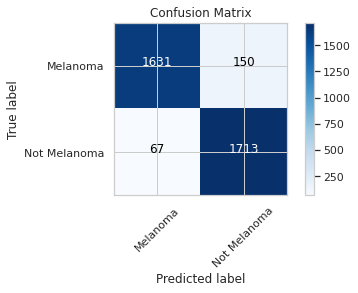

In [ ]:
funct.plot_cm(y_true=test_dataset.classes, y_pred=np.argmax(pred_rn2, axis=-1), classes=["Melanoma", "Not Melanoma"])

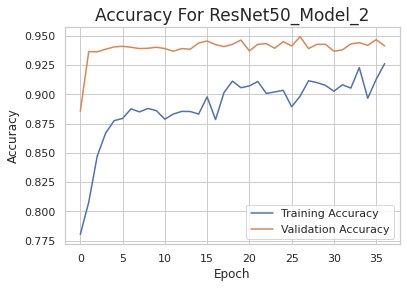

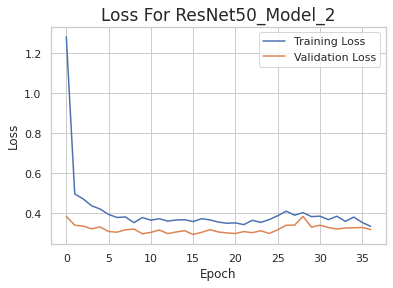

In [ ]:
funct.plot_model_metrics(hist=history_rn2, label='ResNet50_Model_2')

### Third Model

In [ ]:
resnet_model3 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
resnet_3 = Sequential()
resnet_3.add(resnet_model3)
resnet_3.add(layers.Flatten())
resnet_3.add(layers.Dropout(0.5))
resnet_3.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
resnet_3.add(layers.Dropout(0.5))
resnet_3.add(layers.Dense(2, activation='softmax'))

In [ ]:
for layer in resnet_model3.layers[:-5]:
  layer.trainable = False

In [ ]:
resnet_3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_4 (Flatten)         (None, 100352)            0         
                                                                 
 dropout_6 (Dropout)         (None, 100352)            0         
                                                                 
 dense_7 (Dense)             (None, 64)                6422592   
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 2)                 130       
                                                                 
Total params: 30,010,434
Trainable params: 7,477,442
N

In [ ]:
resnet_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])


In [ ]:
log_dir = "/content/drive/MyDrive/Colab Notebooks/logs/fit/resnet_3"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
history_rn3 = resnet_3.fit(train_dataset,
                       validation_data=val_dataset,
                       steps_per_epoch=100,
                       epochs=200,
                       callbacks=[earlystop, tensorboard_callback])

Epoch 1/200
100/100 [==============================] - 67s 634ms/step - loss: 0.9648 - acc: 0.8431 - val_loss: 0.3931 - val_acc: 0.9239
Epoch 2/200
100/100 [==============================] - 62s 621ms/step - loss: 0.4064 - acc: 0.9187 - val_loss: 0.3357 - val_acc: 0.9343
Epoch 3/200
100/100 [==============================] - 62s 617ms/step - loss: 0.3861 - acc: 0.9162 - val_loss: 0.3150 - val_acc: 0.9368
Epoch 4/200
100/100 [==============================] - 61s 617ms/step - loss: 0.3424 - acc: 0.9302 - val_loss: 0.3046 - val_acc: 0.9380
Epoch 5/200
100/100 [==============================] - 62s 619ms/step - loss: 0.3070 - acc: 0.9378 - val_loss: 0.2985 - val_acc: 0.9394
Epoch 6/200
100/100 [==============================] - 62s 619ms/step - loss: 0.3636 - acc: 0.9274 - val_loss: 0.3493 - val_acc: 0.9399
Epoch 7/200
100/100 [==============================] - 62s 620ms/step - loss: 0.3330 - acc: 0.9308 - val_loss: 0.3182 - val_acc: 0.9388
Epoch 8/200
100/100 [===========================

In [ ]:
if os.path.isfile('/content/drive/MyDrive/Colab Notebooks/models/resnet_3.h5') is False:
  resnet_3.save('/content/drive/MyDrive/Colab Notebooks/models/resnet_3.h5')

In [ ]:
resnet_3.evaluate(test_dataset)

112/112 [==============================] - 29s 263ms/step - loss: 0.3171 - acc: 0.9329


[0.3170827329158783, 0.9328840374946594]

In [ ]:
pred_rn3 = resnet_3.predict(test_dataset, verbose=0)
pred_rn3

array([[1.00000000e+00, 1.02472496e-10],
       [1.00000000e+00, 8.44328940e-10],
       [1.00000000e+00, 5.89243433e-17],
       ...,
       [2.33695418e-01, 7.66304553e-01],
       [1.65984388e-02, 9.83401537e-01],
       [2.21530601e-01, 7.78469384e-01]], dtype=float32)

[[1546  235]
 [   4 1776]]


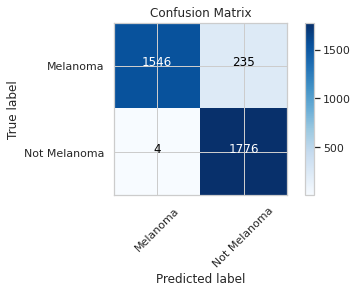

In [ ]:
funct.plot_cm(y_true=test_dataset.classes, y_pred=np.argmax(pred_rn3, axis=-1), classes=["Melanoma", "Not Melanoma"])

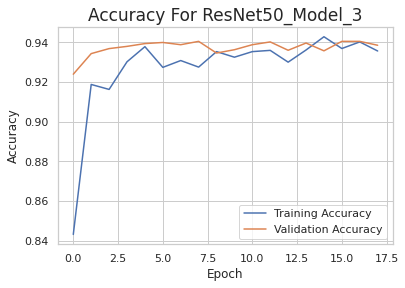

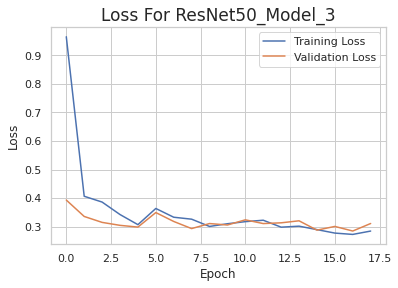

In [ ]:
funct.plot_model_metrics(hist=history_rn3, label='ResNet50_Model_3')